
## tsai 

* https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/15_PatchTST_a_new_transformer_for_LTSF.ipynb
* https://huggingface.co/docs/transformers/en/model_doc/patchtst
* https://github.com/zhouhaoyi/ETDataset/tree/main/ETT-small


In [1]:

# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = True # Set to True for latest pip version or False for main branch in GitHub

## !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null


In [2]:

import sklearn
from tsai.basics import *



In [3]:

my_setup(sklearn)


os              : macOS-10.16-x86_64-i386-64bit
python          : 3.9.18
tsai            : 0.3.9
fastai          : 2.7.15
fastcore        : 1.5.48
sklearn         : 1.5.0
torch           : 2.2.2
device          : mps
cpu cores       : 8
threads per cpu : 1
RAM             : 16.0 GB
GPU memory      : N/A



## Data





In this case, we are going to download the dataframe using get_long_term_forecasting_data. You can use any of the following datasets: "ETTh1", "ETTh2", "ETTm1", "ETTm2", "electricity", "exchange_rate", "traffic", "weather", or "ILI".

We are going to use a small dataset called ILI. ILI includes the weekly recorded influenza-like illness (ILI) patients data from Centers for Disease Control and Prevention of the United States between 2002 and 2021, which describes the ratio of patients seen with ILI and the total number of the patients.

The task is a multivariate long-term time series forecasting (LTSF), where multiple variables are predicted simultaneously for multiple time steps.



In [13]:

dsid = "ETTh1" #"ILI"
### df_raw = get_long_term_forecasting_data(dsid)
df_raw = pd.read_csv("data/ETTh1.csv")
df_raw


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [11]:

datetime_col = "date"
## freq = '7D'
columns = df_raw.columns[1:]
method = 'ffill'
value = 0

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)), # drop duplicate rows (if any)
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)), # ass missing timestamps (if any)
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ], 
    verbose=True)

mkdir('data', exist_ok=True, parents=True)

save_object(preproc_pipe, 'data/preproc_pipe.pkl')
preproc_pipe = load_object('data/preproc_pipe.pkl')

df = preproc_pipe.fit_transform(df_raw)
df


data directory already exists.
Pipeline saved as data/preproc_pipe.pkl
Initial memory usage: 1.06 MB   
Final memory usage  : 612.55 KB  (-43.7%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.0s


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01,5.827000,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-08,11.855000,4.756,8.884,2.985,2.955,1.523,31.093000
2,2016-07-15,13.195000,4.019,8.422,2.097,4.782,1.462,31.304001
3,2016-07-22,17.816999,6.162,11.975,3.589,5.818,1.584,36.651001
4,2016-07-29,17.214001,4.153,12.579,1.812,5.056,1.310,39.675999
...,...,...,...,...,...,...,...,...
99,2018-05-25,15.807000,6.095,10.803,4.193,4.538,1.310,8.723000
100,2018-06-01,13.530000,4.957,9.239,2.985,4.538,1.432,8.512000
101,2018-06-08,15.740000,5.492,10.305,2.914,4.904,1.462,10.482000
102,2018-06-15,16.209000,6.631,10.980,4.015,5.239,1.706,10.200000


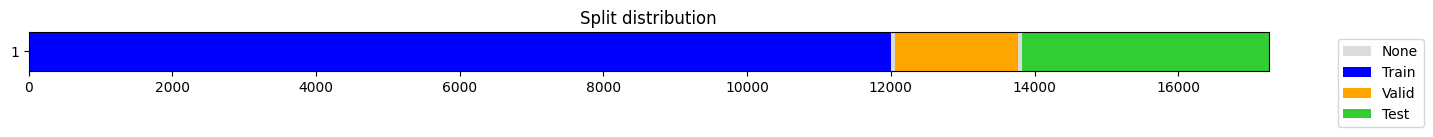

((#11997) [0,1,2,3,4,5,6,7,8,9...],
 (#1714) [12056,12057,12058,12059,12060,12061,12062,12063,12064,12065...],
 (#3428) [13829,13830,13831,13832,13833,13834,13835,13836,13837,13838...])

In [14]:
df = df_raw

fcst_history = 104 # # steps in the past
fcst_horizon = 60  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
splits


In [15]:

columns = df.columns[1:]
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)
save_object(exp_pipe, 'data/exp_pipe.pkl')
exp_pipe = load_object('data/exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled
     


data directory already exists.
Pipeline saved as data/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,-0.253474,0.030367,-0.477174,-0.115520,1.074705,0.850958,1.692701
1,2016-07-01 01:00:00,-0.274492,0.061916,-0.494492,-0.134090,1.023729,0.897545,1.362782
2,2016-07-01 02:00:00,-0.358563,-0.095830,-0.528967,-0.170713,0.718705,0.667615,1.362782
3,2016-07-01 03:00:00,-0.369072,-0.001182,-0.528967,-0.152144,0.743775,0.759287,1.032983
4,2016-07-01 04:00:00,-0.327037,-0.001182,-0.494492,-0.115520,0.794752,0.759287,0.660742
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.430000,0.755998,-1.644777,0.745898,0.463822,1.125973,-0.667111
17416,2018-06-26 16:00:00,-2.028850,1.103038,-2.214012,0.819145,0.514799,1.354400,-0.650279
17417,2018-06-26 17:00:00,-0.726218,0.882194,-0.868209,0.727845,0.667728,1.125973,-0.743219
17418,2018-06-26 18:00:00,0.282322,0.882194,0.149680,0.727845,0.616752,0.989217,-0.802494


In [19]:



x_vars = df.columns[1:]
y_vars = df.columns[1:]
     

X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape
     
X = np.float32(X)
y = np.float32(y)


In [20]:



arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.0, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=24,  # length of the patch applied to the time series to create patches
    stride=2,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)
     

learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())
     



In [21]:

learn.summary()


not enough values to plot a chart


PatchTST (Input shape: 16 x 7 x 104)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 7 x 60         
RevIN                                     14         True      
____________________________________________________________________________
                     16 x 7 x 106        
ReplicationPad1d                                               
____________________________________________________________________________
                     16 x 24 x 42        
Unfold                                                         
____________________________________________________________________________
                     16 x 7 x 42 x 16    
Linear                                    400        True      
Dropout                                                        
Linear                                    272        True      
Linear                                    272        True      
Linear                                    272       

epoch,train_loss,valid_loss,mse,mae,time
0,0.352424,0.322037,0.322037,0.374431,00:55
1,0.337427,0.314127,0.314127,0.368704,00:49
2,0.333506,0.312635,0.312635,0.368707,00:49
3,0.337364,0.311677,0.311677,0.367297,00:50
4,0.314510,0.310422,0.310422,0.367947,00:50
5,0.319755,0.310967,0.310967,0.368998,00:49
6,0.319113,0.308360,0.308360,0.368613,00:50
7,0.323713,0.308366,0.308366,0.368761,00:51
8,0.330758,0.306972,0.306972,0.369097,00:51
9,0.331148,0.313547,0.313547,0.370938,00:51


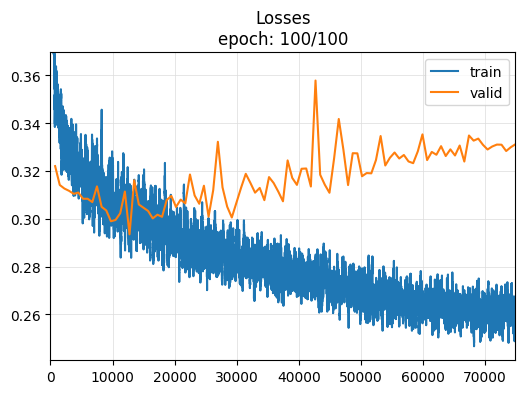

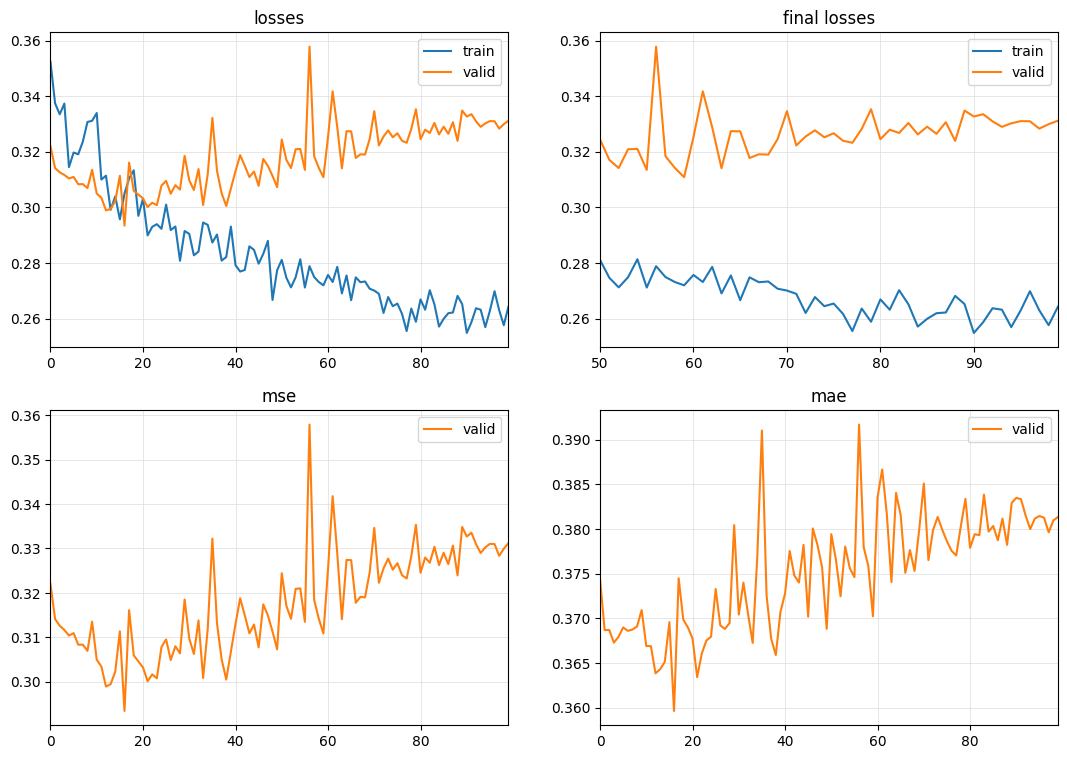

In [22]:

## lr_max = learn.lr_find().valley


learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=[ShowGraph()])

n_epochs = 100
lr_max = 0.0025
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST.pt')
     



In [23]:

from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
scaled_preds, *_ = learn.get_X_preds(X[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")

scaled_y_true = y[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df


scaled_preds.shape: (1714, 7, 60)


,mse,mae
valid,0.331199,0.381339


In [24]:

from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df


y_test_preds.shape: (3428, 7, 60)


,mse,mae
test,0.395199,0.42607


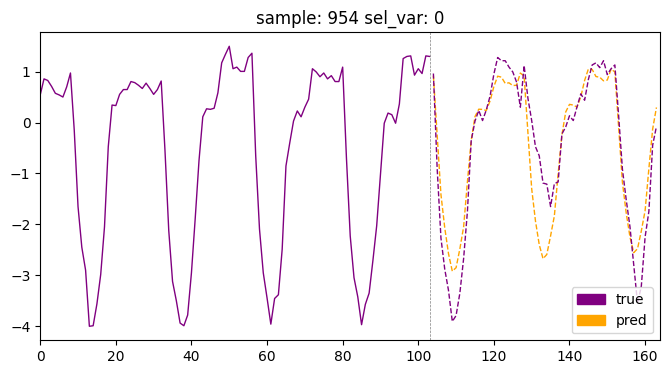

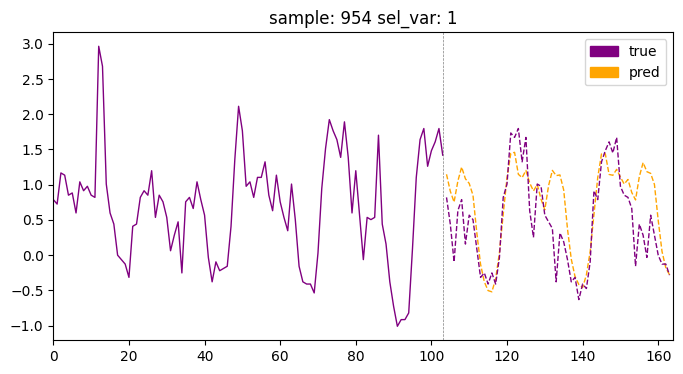

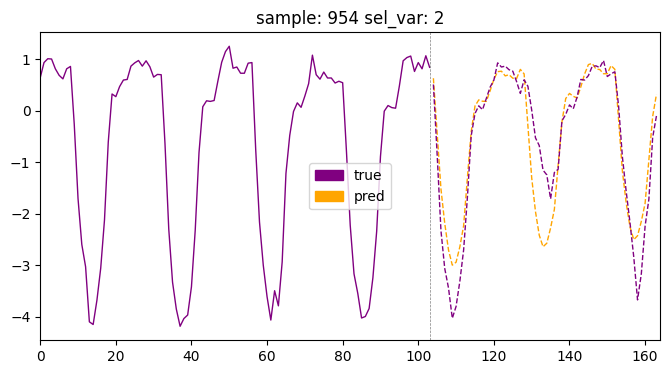

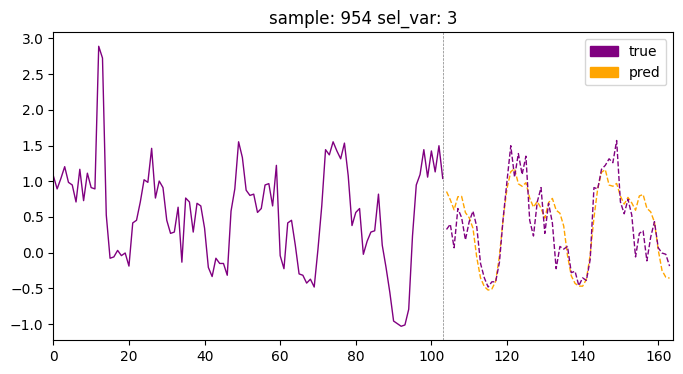

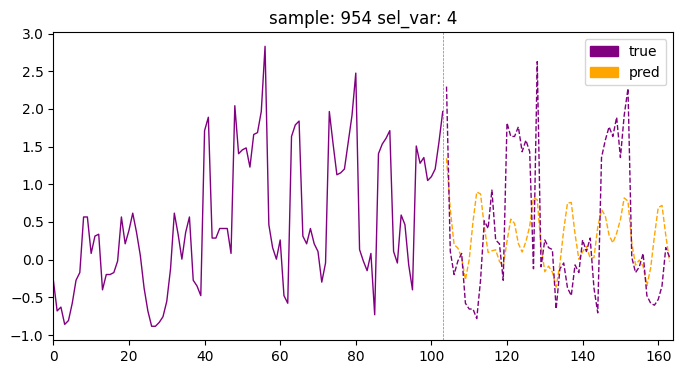

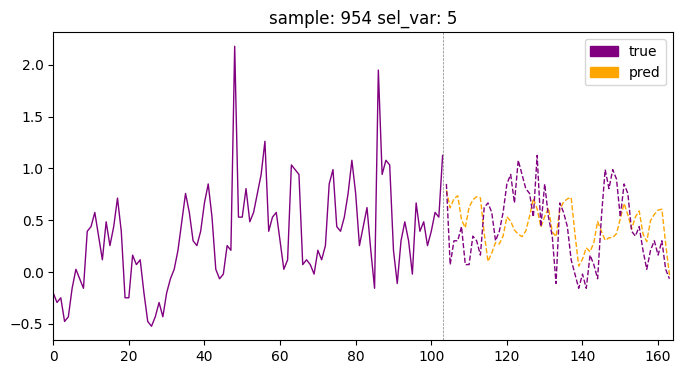

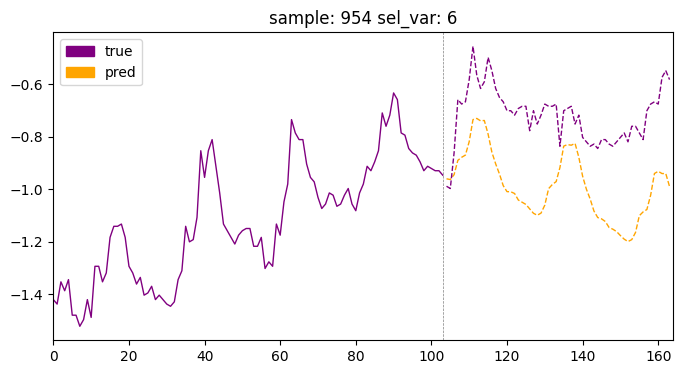

In [25]:

X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)
